<a href="https://colab.research.google.com/github/muhammadahmad62/Demand_Forecasting/blob/main/Demand_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [494]:
import pandas as pd
import numpy as np
!pip install pystan==2.19.1.1
!pip install prophet
from prophet import Prophet

In [495]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [496]:
forecasting_df = pd.read_excel("drive/My Drive/Demand_Forecasting/OrdersData.xlsx")

In [497]:
forecasting_df

,Order Id.,ProductName,OrderStatus,ItemStatus,ShipCity,ShipCountry,Asin,Quantity,ShipTo,SubmittedAt,orderNumber,orderKey,merchantOrderIdr,purchaseDate,createDate,paymentDate,lastUpdatedDate,Orderstatus,fulfillmentChannel,salesChannel,orderChannel,shipServiceLevel,items,shipTo,billTo,financial_status,itemPrice,itemTax,subTotalPrice,weight,shippingPrice,shippingTax,giftWrapTax
0,111-3770605-1818618,County Line Kitchen - Cold Brew Mason Jar iced...,Pending,Unshipped,UNION CITY,US,B08T1LVXL1,1,"undefined,undefined,undefined,undefined","Nov 18, 2021 10:09 AM",NaN,NaN,111-3770605-1818618,2021-11-18T09:52:17+00:00,NaN,NaN,2021-11-18T09:52:22+00:00,Pending,Amazon,Amazon.com,NaN,Standard,[],[],[],NaN,19.99,NaN,NaN,NaN,NaN,NaN,NaN
1,113-8387406-0690630,Moen 87233SRS Adler One-Handle High Arc Pulldo...,Pending,Unshipped,CEDAR GROVE,US,B08NK6B9XY,1,"undefined,undefined,undefined,undefined","Nov 18, 2021 5:59 AM",NaN,NaN,113-8387406-0690630,2021-11-18T05:41:48+00:00,NaN,NaN,2021-11-18T05:41:54+00:00,Pending,Amazon,Amazon.com,NaN,Expedited,[],[],[],NaN,17.49,NaN,NaN,NaN,NaN,NaN,NaN
2,112-4214202-0755421,County Line Kitchen - Cold Brew Mason Jar iced...,Pending,Unshipped,OCEAN,US,B08T1LVXL1,1,"undefined,undefined,undefined,undefined","Nov 18, 2021 1:01 AM",NaN,NaN,112-4214202-0755421,2021-11-18T00:55:43+00:00,NaN,NaN,2021-11-18T00:55:48+00:00,Pending,Amazon,Amazon.com,NaN,Standard,[],[],[],NaN,19.99,NaN,NaN,NaN,NaN,NaN,NaN
3,111-0046859-3622639,Moen 87233SRS Adler One-Handle High Arc Pulldo...,Pending,Unshipped,HERMITAGE,US,B08NK6B9XY,2,"undefined,undefined,undefined,undefined","Nov 18, 2021 12:01 AM",NaN,NaN,111-0046859-3622639,2021-11-17T23:56:06+00:00,NaN,NaN,2021-11-17T23:56:10+00:00,Pending,Amazon,Amazon.com,NaN,Expedited,[],[],[],NaN,34.98,NaN,NaN,NaN,NaN,NaN,NaN
4,702-7123373-3054650,COOK WITH COLOR Plastic Mixing Bowls with Lids...,Cancelled,Cancelled,Eckville,CA,B08NK6B9XY,0,"undefined,undefined,undefined,undefined","Nov 17, 2021 2:01 AM",NaN,NaN,702-7123373-3054650,2021-11-17T01:48:14+00:00,NaN,NaN,2021-11-17T01:48:53+00:00,Cancelled,Amazon,Amazon.ca,NaN,Expedited,[],[],[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2136,702-6176273-3440252,DASH Rapid Egg Cooker: 6 Egg Capacity Electric...,Shipped,Shipped,orangeville,CA,B08YZ5JV1F,1,"undefined,undefined,undefined,undefined","Sep 23, 2021 2:02 PM",NaN,NaN,702-6176273-3440252,2021-09-07T02:24:37+00:00,NaN,NaN,2021-09-09T07:23:25+00:00,Shipped,Amazon,Amazon.ca,NaN,Standard,[],[],[],NaN,29.98,NaN,NaN,NaN,NaN,NaN,NaN
2137,702-3465091-2166603,Smart Guesser Digital Meat Thermometer with Ba...,Shipped,Shipped,Saint-Tite,CA,B08NP4PSBF,1,"undefined,undefined,undefined,undefined","Sep 23, 2021 2:02 PM",NaN,NaN,702-3465091-2166603,2021-09-07T03:50:20+00:00,NaN,NaN,2021-09-09T22:26:09+00:00,Shipped,Amazon,Amazon.ca,NaN,Standard,[],[],[],NaN,24.67,NaN,NaN,NaN,NaN,NaN,NaN
2138,702-2478747-2860208,DASH DCAF200GBBK02 Tasti Crisp Electric Air Fr...,Shipped,Shipped,Clarke’s Beach,CA,B08TH8GXJW,1,"undefined,undefined,undefined,undefined","Sep 23, 2021 2:02 PM",NaN,NaN,702-2478747-2860208,2021-09-07T15:36:07+00:00,NaN,NaN,2021-09-08T10:24:03+00:00,Shipped,Amazon,Amazon.ca,NaN,Standard,[],[],[],NaN,55.52,NaN,NaN,NaN,16.38,NaN,NaN
2139,701-2498907-2157820,DASH DCAF200GBBK02 Tasti Crisp Electric Air Fr...,Shipped,Shipped,Laval,CA,B08TH8GXJW,1,"undefined,undefined,undefined,undefined","Sep 23, 2021 2:02 PM",NaN,NaN,701-2498907-2157820,2021-09-12T22:40:50+00:00,NaN,NaN,2021-09-15T22:10:53+00:00,Shipped,Amazon,Amazon.ca,NaN,Standard,[],[],[],NaN,55.52,NaN,NaN,NaN,NaN,NaN,NaN


In [498]:
forecasting_df.describe()

,Quantity,orderNumber,orderKey,createDate,paymentDate,financial_status,itemPrice,itemTax,subTotalPrice,weight,shippingPrice,shippingTax,giftWrapTax
count,2141.000000,0.0,0.0,0.0,0.0,0.0,1993.000000,1599.000000,0.0,0.0,147.000000,20.000000,4.000000
mean,1.248949,NaN,NaN,NaN,NaN,NaN,27.899854,2.097223,NaN,NaN,5.632721,0.469500,0.390000
std,4.157546,NaN,NaN,NaN,NaN,NaN,26.711145,2.097852,NaN,NaN,3.492933,0.221964,0.094163
min,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.450000,NaN,NaN,0.340000,0.070000,0.290000
25%,1.000000,NaN,NaN,NaN,NaN,NaN,19.980000,1.260000,NaN,NaN,2.755000,0.335000,0.320000
50%,1.000000,NaN,NaN,NaN,NaN,NaN,24.990000,1.800000,NaN,NaN,5.900000,0.485000,0.395000
75%,1.000000,NaN,NaN,NaN,NaN,NaN,29.990000,2.310000,NaN,NaN,7.900000,0.620000,0.465000
max,149.000000,NaN,NaN,NaN,NaN,NaN,441.680000,36.260000,NaN,NaN,16.380000,0.800000,0.480000


In [499]:
forecasting_drop.isnull().sum()

ProductName         0
OrderStatus         0
ItemStatus          0
ShipCity            0
ShipCountry         0
Quantity            0
purchaseDate        0
salesChannel        0
shipServiceLevel    0
itemPrice           0
itemTax             0
shippingPrice       0
shippingTax         0
dtype: int64

In [500]:
forecasting_drop = forecasting_df.drop(['ShipTo','orderNumber','orderKey','createDate','paymentDate','orderChannel','items','shipTo','billTo','financial_status','subTotalPrice','weight','giftWrapTax','Order Id.','Asin','merchantOrderIdr','fulfillmentChannel','Orderstatus','SubmittedAt','lastUpdatedDate'],axis=1)

In [501]:
forecasting_drop

,ProductName,OrderStatus,ItemStatus,ShipCity,ShipCountry,Quantity,purchaseDate,salesChannel,shipServiceLevel,itemPrice,itemTax,shippingPrice,shippingTax
0,County Line Kitchen - Cold Brew Mason Jar iced...,Pending,Unshipped,UNION CITY,US,1,2021-11-18T09:52:17+00:00,Amazon.com,Standard,19.99,NaN,NaN,NaN
1,Moen 87233SRS Adler One-Handle High Arc Pulldo...,Pending,Unshipped,CEDAR GROVE,US,1,2021-11-18T05:41:48+00:00,Amazon.com,Expedited,17.49,NaN,NaN,NaN
2,County Line Kitchen - Cold Brew Mason Jar iced...,Pending,Unshipped,OCEAN,US,1,2021-11-18T00:55:43+00:00,Amazon.com,Standard,19.99,NaN,NaN,NaN
3,Moen 87233SRS Adler One-Handle High Arc Pulldo...,Pending,Unshipped,HERMITAGE,US,2,2021-11-17T23:56:06+00:00,Amazon.com,Expedited,34.98,NaN,NaN,NaN
4,COOK WITH COLOR Plastic Mixing Bowls with Lids...,Cancelled,Cancelled,Eckville,CA,0,2021-11-17T01:48:14+00:00,Amazon.ca,Expedited,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2136,DASH Rapid Egg Cooker: 6 Egg Capacity Electric...,Shipped,Shipped,orangeville,CA,1,2021-09-07T02:24:37+00:00,Amazon.ca,Standard,29.98,NaN,NaN,NaN
2137,Smart Guesser Digital Meat Thermometer with Ba...,Shipped,Shipped,Saint-Tite,CA,1,2021-09-07T03:50:20+00:00,Amazon.ca,Standard,24.67,NaN,NaN,NaN
2138,DASH DCAF200GBBK02 Tasti Crisp Electric Air Fr...,Shipped,Shipped,Clarke’s Beach,CA,1,2021-09-07T15:36:07+00:00,Amazon.ca,Standard,55.52,NaN,16.38,NaN
2139,DASH DCAF200GBBK02 Tasti Crisp Electric Air Fr...,Shipped,Shipped,Laval,CA,1,2021-09-12T22:40:50+00:00,Amazon.ca,Standard,55.52,NaN,NaN,NaN


In [502]:
product_name = forecasting_drop.ProductName.unique()
product_dict = dict(zip(product_name,range(len(product_name))))

orderStatus = forecasting_drop.OrderStatus.unique()
order_dict = dict(zip(orderStatus,range(len(orderStatus))))

item_status = forecasting_drop.ItemStatus.unique()
item_dict = dict(zip(item_status,range(len(item_status))))

shipCity = forecasting_drop.ShipCity.unique()
city_dict = dict(zip(shipCity,range(len(shipCity))))

shipCountry = forecasting_drop.ShipCountry.unique()
country_dict = dict(zip(shipCountry,range(len(shipCountry))))

salesChannel = forecasting_drop.salesChannel.unique()
channel_dict = dict(zip(salesChannel,range(len(salesChannel))))

shipServiceLevel = forecasting_drop.shipServiceLevel.unique()
service_level_dict = dict(zip(shipServiceLevel,range(len(shipServiceLevel))))


In [503]:
forecasting_drop = forecasting_drop.replace({'ProductName':product_dict,'OrderStatus':order_dict,'ProductName':product_dict,'ItemStatus':item_dict,'ShipCity':city_dict,'ShipCountry':country_dict,'salesChannel':channel_dict,'shipServiceLevel':service_level_dict})

In [504]:
forecasting_drop['itemTax'] = forecasting_drop['itemTax'].fillna(0)
forecasting_drop['shippingPrice'] = forecasting_drop['shippingPrice'].fillna(0)
forecasting_drop['shippingTax'] = forecasting_drop['shippingTax'].fillna(0)
forecasting_drop['itemPrice'] = forecasting_drop['itemPrice'].fillna(0)

In [505]:
forecasting_drop.describe()

,ProductName,OrderStatus,ItemStatus,ShipCity,ShipCountry,Quantity,salesChannel,shipServiceLevel,itemPrice,itemTax,shippingPrice,shippingTax
count,2141.000000,2141.000000,2141.000000,2141.000000,2141.000000,2141.000000,2141.000000,2141.000000,2141.000000,2141.000000,2141.00000,2141.000000
mean,5.758991,1.893508,1.808034,657.462401,0.108828,1.248949,0.146193,0.881831,25.971233,1.566305,0.38674,0.004386
std,3.188153,0.421235,0.567048,439.068320,0.522236,4.157546,0.463248,0.507469,26.725522,2.029362,1.69179,0.049782
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,4.000000,2.000000,2.000000,263.000000,0.000000,1.000000,0.000000,1.000000,14.990000,0.000000,0.00000,0.000000
50%,5.000000,2.000000,2.000000,606.000000,0.000000,1.000000,0.000000,1.000000,24.670000,1.470000,0.00000,0.000000
75%,8.000000,2.000000,2.000000,1024.000000,0.000000,1.000000,0.000000,1.000000,29.990000,2.100000,0.00000,0.000000
max,28.000000,3.000000,3.000000,1512.000000,8.000000,149.000000,3.000000,4.000000,441.680000,36.260000,16.38000,0.800000


In [506]:
forecasting_drop

,ProductName,OrderStatus,ItemStatus,ShipCity,ShipCountry,Quantity,purchaseDate,salesChannel,shipServiceLevel,itemPrice,itemTax,shippingPrice,shippingTax
0,0,0,0,0,0,1,2021-11-18T09:52:17+00:00,0,0,19.99,0.0,0.00,0.0
1,1,0,0,1,0,1,2021-11-18T05:41:48+00:00,0,1,17.49,0.0,0.00,0.0
2,0,0,0,2,0,1,2021-11-18T00:55:43+00:00,0,0,19.99,0.0,0.00,0.0
3,1,0,0,3,0,2,2021-11-17T23:56:06+00:00,0,1,34.98,0.0,0.00,0.0
4,2,1,1,4,1,0,2021-11-17T01:48:14+00:00,1,1,0.00,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2136,9,2,2,1508,1,1,2021-09-07T02:24:37+00:00,1,0,29.98,0.0,0.00,0.0
2137,6,2,2,1509,1,1,2021-09-07T03:50:20+00:00,1,0,24.67,0.0,0.00,0.0
2138,4,2,2,1510,1,1,2021-09-07T15:36:07+00:00,1,0,55.52,0.0,16.38,0.0
2139,4,2,2,1511,1,1,2021-09-12T22:40:50+00:00,1,0,55.52,0.0,0.00,0.0


In [507]:
forecasting_drop

,ProductName,OrderStatus,ItemStatus,ShipCity,ShipCountry,Quantity,purchaseDate,salesChannel,shipServiceLevel,itemPrice,itemTax,shippingPrice,shippingTax
0,0,0,0,0,0,1,2021-11-18T09:52:17+00:00,0,0,19.99,0.0,0.00,0.0
1,1,0,0,1,0,1,2021-11-18T05:41:48+00:00,0,1,17.49,0.0,0.00,0.0
2,0,0,0,2,0,1,2021-11-18T00:55:43+00:00,0,0,19.99,0.0,0.00,0.0
3,1,0,0,3,0,2,2021-11-17T23:56:06+00:00,0,1,34.98,0.0,0.00,0.0
4,2,1,1,4,1,0,2021-11-17T01:48:14+00:00,1,1,0.00,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2136,9,2,2,1508,1,1,2021-09-07T02:24:37+00:00,1,0,29.98,0.0,0.00,0.0
2137,6,2,2,1509,1,1,2021-09-07T03:50:20+00:00,1,0,24.67,0.0,0.00,0.0
2138,4,2,2,1510,1,1,2021-09-07T15:36:07+00:00,1,0,55.52,0.0,16.38,0.0
2139,4,2,2,1511,1,1,2021-09-12T22:40:50+00:00,1,0,55.52,0.0,0.00,0.0


In [508]:
column_values = forecasting_drop[["ProductName"]].values.ravel()

unique_values =  pd.unique(column_values)

In [509]:
unique_values

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28])

In [510]:
forecasting_drop.drop(forecasting_drop[forecasting_drop['itemPrice'] == 0].index,inplace = True)

In [511]:
# forecasting_drop.loc[forecasting_drop['ProductName'] == 18]
forecasting_drop.reset_index(drop=True)
# forecasting_drop.where(forecasting_drop.isnull().all(axis=1), forecasting_drop.fillna(100), inplace=True)

,ProductName,OrderStatus,ItemStatus,ShipCity,ShipCountry,Quantity,purchaseDate,salesChannel,shipServiceLevel,itemPrice,itemTax,shippingPrice,shippingTax
0,0,0,0,0,0,1,2021-11-18T09:52:17+00:00,0,0,19.99,0.0,0.00,0.0
1,1,0,0,1,0,1,2021-11-18T05:41:48+00:00,0,1,17.49,0.0,0.00,0.0
2,0,0,0,2,0,1,2021-11-18T00:55:43+00:00,0,0,19.99,0.0,0.00,0.0
3,1,0,0,3,0,2,2021-11-17T23:56:06+00:00,0,1,34.98,0.0,0.00,0.0
4,3,0,0,5,0,1,2021-11-16T19:49:52+00:00,0,1,24.99,0.0,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1955,9,2,2,1508,1,1,2021-09-07T02:24:37+00:00,1,0,29.98,0.0,0.00,0.0
1956,6,2,2,1509,1,1,2021-09-07T03:50:20+00:00,1,0,24.67,0.0,0.00,0.0
1957,4,2,2,1510,1,1,2021-09-07T15:36:07+00:00,1,0,55.52,0.0,16.38,0.0
1958,4,2,2,1511,1,1,2021-09-12T22:40:50+00:00,1,0,55.52,0.0,0.00,0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:prophet:n_changepoints greater than number of observations. Using 20.


27
0      0
2      0
6      0
7      0
9      0
10     0
11     0
12     0
13     0
16     0
18     0
19     0
22     0
23     0
29     0
32     0
33     0
37     0
39     0
43     0
44     0
52     0
55     0
56     0
59     0
68     0
229    0
Name: ProductName, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 1.


3
1    1
3    1
8    1
Name: ProductName, dtype: int64
94
14      2
30      2
246     2
362     2
547     2
       ..
1968    2
1998    2
1999    2
2127    2
2130    2
Name: ProductName, Length: 94, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



154
5       3
340     3
344     3
347     3
348     3
       ..
1215    3
1224    3
1311    3
1758    3
1923    3
Name: ProductName, Length: 154, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



433
17      4
20      4
21      4
25      4
27      4
       ..
2113    4
2125    4
2131    4
2138    4
2139    4
Name: ProductName, Length: 433, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



545
24      5
26      5
34      5
57      5
81      5
       ..
1959    5
2071    5
2090    5
2106    5
2123    5
Name: ProductName, Length: 545, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



197
38      6
40      6
61      6
62      6
97      6
       ..
2132    6
2133    6
2134    6
2135    6
2137    6
Name: ProductName, Length: 197, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

16
42      7
45      7
84      7
143     7
181     7
204     7
442     7
1166    7
1187    7
2034    7
2043    7
2098    7
2101    7
2110    7
2112    7
2114    7
Name: ProductName, dtype: int64
230
47      8
49      8
63      8
86      8
218     8
       ..
2076    8
2077    8
2078    8
2083    8
2115    8
Name: ProductName, Length: 230, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



199
72      9
105     9
139     9
227     9
257     9
       ..
2062    9
2066    9
2128    9
2129    9
2136    9
Name: ProductName, Length: 199, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

0
3
339     11
494     11
1116    11
Name: ProductName, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:prophet:n_changepoints greater than number of observations. Using 20.


27
444    12
447    12
448    12
474    12
504    12
505    12
506    12
508    12
512    12
513    12
515    12
523    12
524    12
525    12
528    12
529    12
530    12
531    12
532    12
536    12
538    12
539    12
542    12
544    12
548    12
551    12
552    12
Name: ProductName, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:prophet:n_changepoints greater than number of observations. Using 7.


10
360     13
795     13
1159    13
1162    13
1346    13
1354    13
1358    13
1360    13
1369    13
1382    13
Name: ProductName, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 2.


0
4
454    15
455    15
473    15
573    15
Name: ProductName, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 1.


3
460    16
511    16
574    16
Name: ProductName, dtype: int64
0


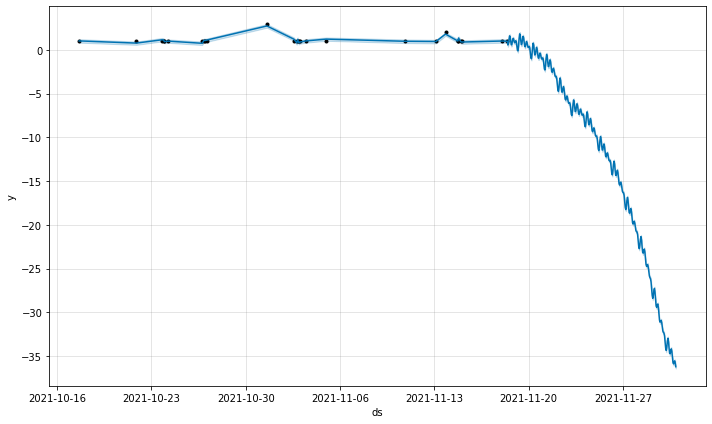

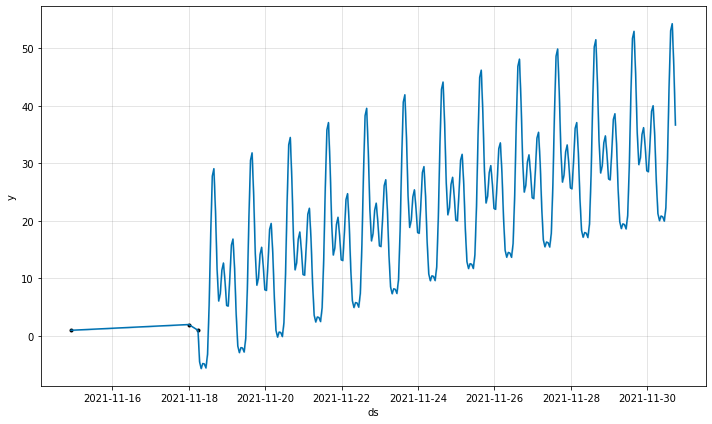

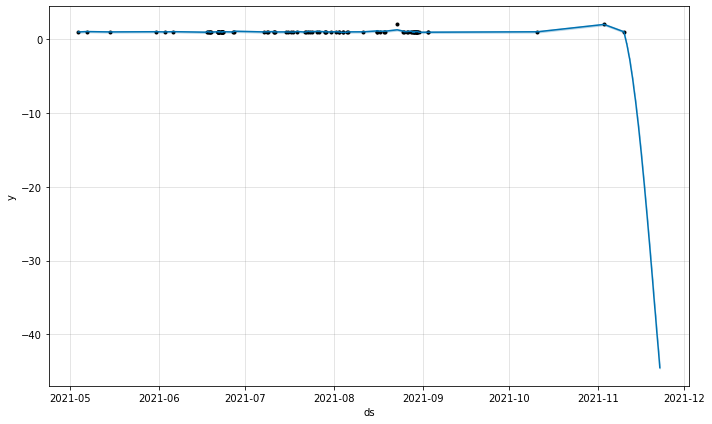

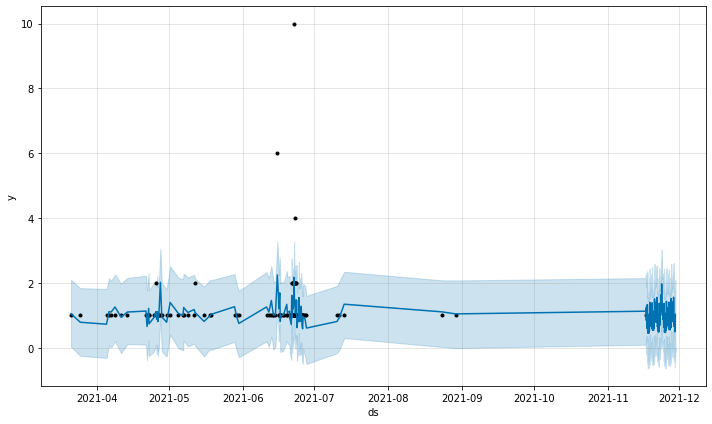

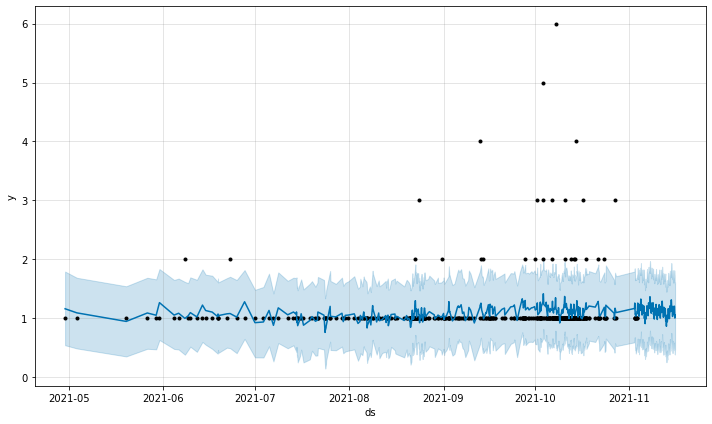

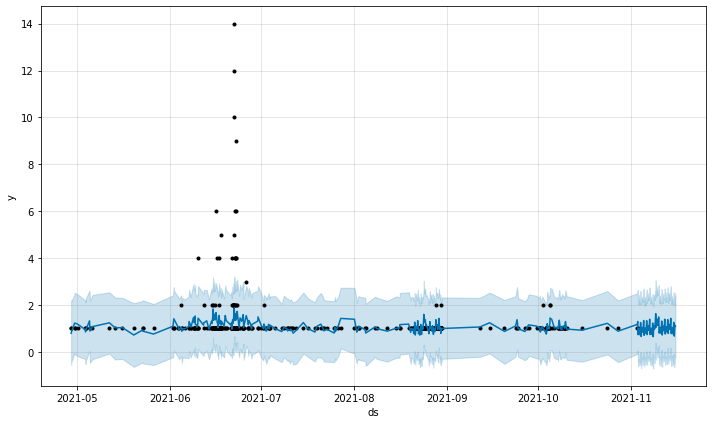

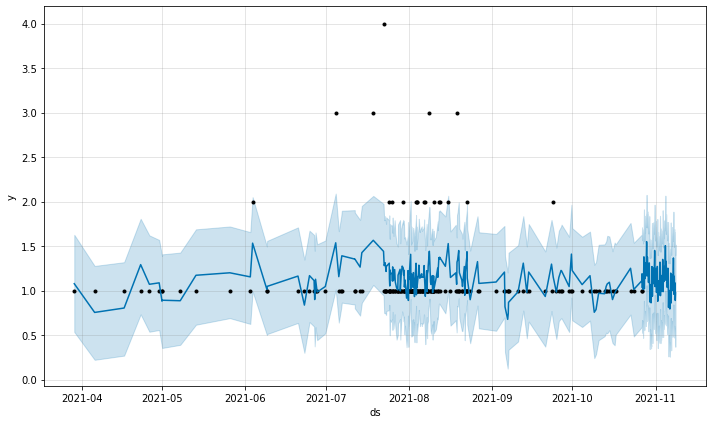

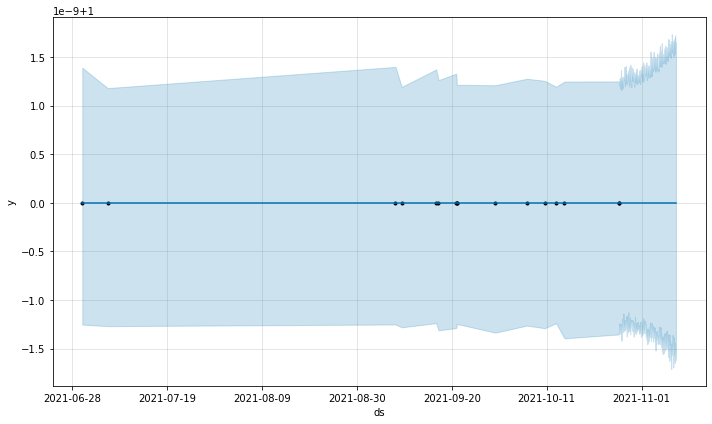

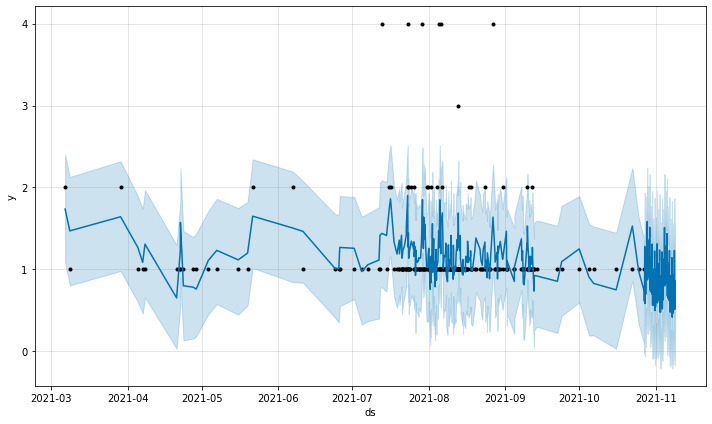

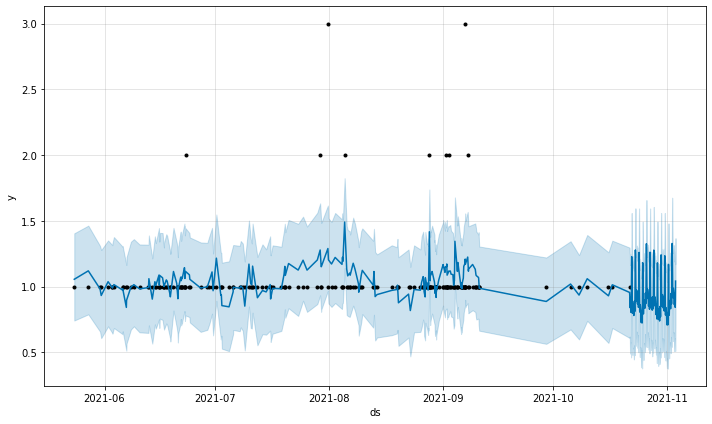

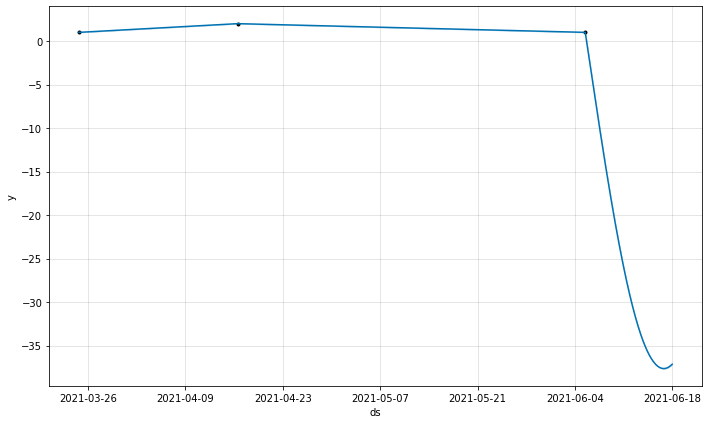

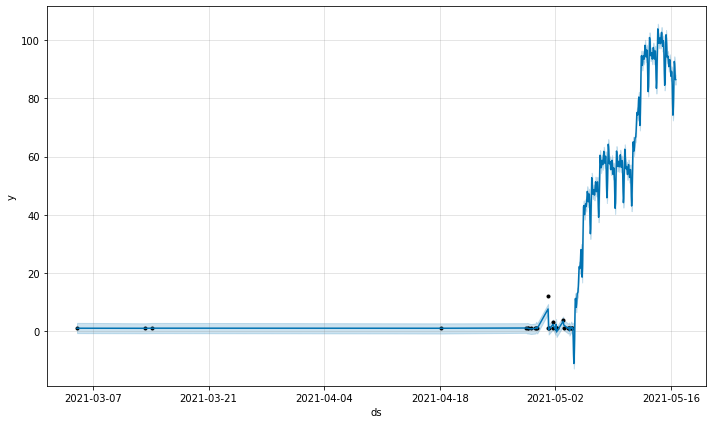

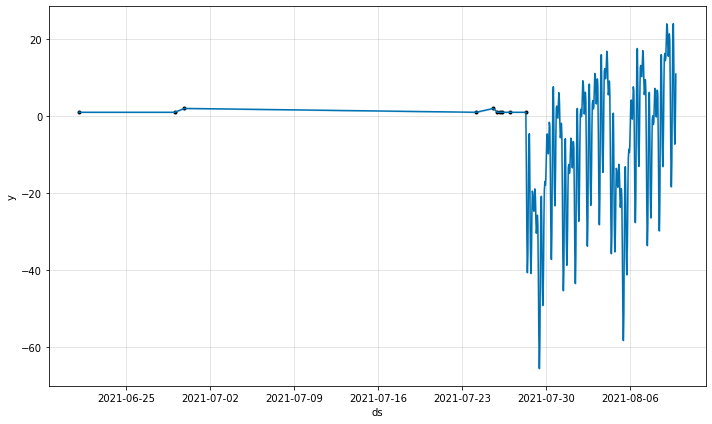

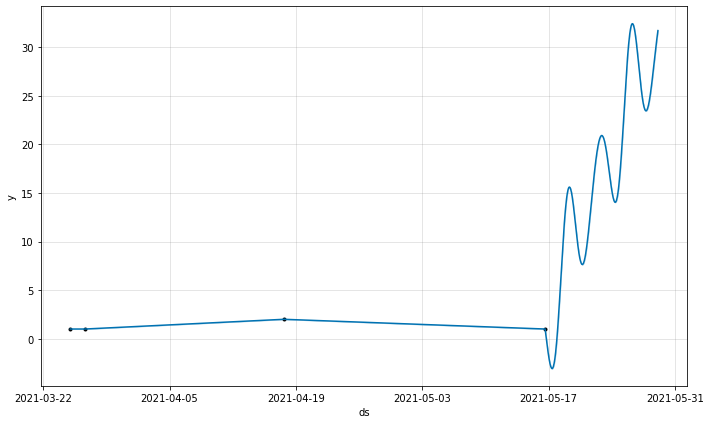

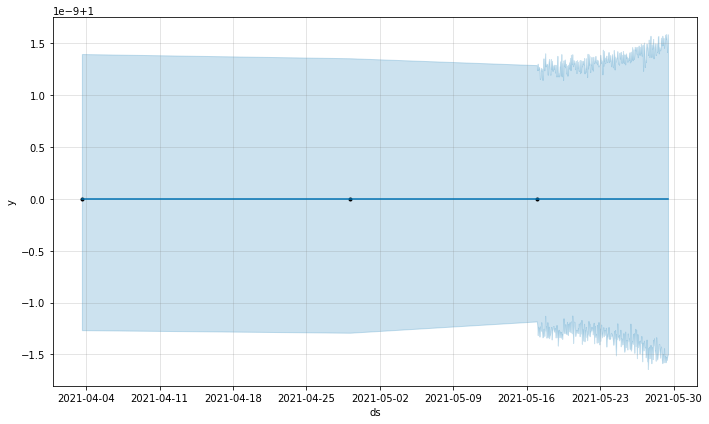

In [512]:
i = 0
for i in range(18):
  product1 = forecasting_drop.loc[forecasting_drop['ProductName'] == i]
  # product1 = product1[product1['ProductName'].notna()]
  if not (product1.empty):
    product1['purchaseDate'] = pd.to_datetime(product1.purchaseDate) 
    product1['purchaseDate'] = product1['purchaseDate'].dt.tz_localize(None)
    product1 = product1.rename(columns={'Quantity':'y','purchaseDate':'ds'})
    # product1 = product1[product1['ProductName'].notna()]
    m = Prophet(changepoint_prior_scale=0.01,yearly_seasonality=True).fit(product1)
    future = m.make_future_dataframe(periods=300, freq='H')
    fcst = m.predict(future)
    fig = m.plot(fcst)